# Client Segmentation Clustering

We have a dataset about the stocks management of a company. We have data about orders made by different clients and also other type of transactions like shippment orders, bank transactions stock balancing transactions, etc.

We need to focus only on the proper customer transactions and group the customers in certain clusters based on their behaviours

### Importing the dataset

We need to change the default encondig because of some characters in the dataset

In [ ]:
import pandas as pd

df = pd.read_csv('data.csv', encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#### Dataset Description:
- InvoiceNo :    Code representing each unique transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode :   Code uniquely assigned to each distinct product.
- Description :	Description of each product.
- Quantity :	    The number of units of a product in a transaction.
- InvoiceDate :	The date and time of the transaction.
- UnitPrice :	    The unit price of the product in pounds.
- CustomerID :	Identifier uniquely assigned to each customer.
- Country :	    The country of the customer.

We want to see how many rows and columns we have

- we have 541909 rows and 8 columns

In [ ]:
df.shape

(541909, 8)

We want to see what types of data we have

1. We notice that we have some columns that are normally numeric ones like InvoiceNo, StockCode that are now as objects because they also contain letters, we will need to somehow convert these to numeric type

2. We also notice that InvoiceDate is object and we will convert it to datetype

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Data cleaning

### Handling null values:

We want to see the features with null values

Since we want to observe the behaviour of customers we need to get rid of the data without 'Customer ID'

In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

By deleting all the 'CustomerID' rows with null values it will remove also all the rows from 'Description' that have null values because the rows match

In [ ]:
df.dropna(subset=['CustomerID'], inplace=True, axis=0)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Checking duplicates

We have duplicates but we want to see if they are legit orders or not

In [ ]:
duplicated_rows = df[df.duplicated(keep=False)]
duplicated_rows = duplicated_rows.sort_values(by=['InvoiceNo', 'StockCode'])
duplicated_rows.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


We see that there are duplicates but it seems that the system allows buying the same product multiple times on an order

We see that on the same InvoiceNO '536381' we have the same product '71270' added with different quantities - this makes us think that it is possible to have the same product mutiple times on the same order with the same or different 'Quantity'
Here it depeends a lot on how the sales flows are in a company and how the invoices are structured.

In [ ]:
# Group by 'orderID' and 'product_code', then filter based on multiple occurrences with different quantities
duplicate_orders = df[df.duplicated(subset=['InvoiceNo', 'StockCode'], keep=False)]

print("Orders with the same product_code brought multiple times with different quantities:")
duplicate_orders.head()

Orders with the same product_code brought multiple times with different quantities:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
113,536381,71270,PHOTO CLIP LINE,1,12/1/2010 9:41,1.25,15311.0,United Kingdom
125,536381,71270,PHOTO CLIP LINE,3,12/1/2010 9:41,1.25,15311.0,United Kingdom
483,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,3,12/1/2010 11:45,6.35,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


### Remove data that is not a proper product transaction 

First we need to check what StockCodes we have, we can see that we have some stock codes that are not starting with a numeric value, these are
bank charges, carriege fees, amazon fees, transport related transactions, etc. We can drop these rows because they don't help us at all 

In [ ]:
non_numeric_stocks = df[~df['StockCode'].str.contains('^\\d', na=False)]
non_numeric_stocks['StockCode'].value_counts()

StockCode
POST            1196
M                465
C2               134
D                 77
DOT               16
CRUK              16
BANK CHARGES      12
PADS               4
Name: count, dtype: int64

We drop these rows

In [ ]:
print(df.shape)
df.drop(index=non_numeric_stocks.index, inplace=True)
print(df.shape)

(406829, 8)
(404909, 8)


We want to see what UnitPrices we have

We notice that we have some rows with UnitPrices equal to 0 - these do not help us at all

In [ ]:
df['UnitPrice'].describe()

count    404909.000000
mean          2.901129
std           4.430846
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

We notice that we have 33 rows where UnitPrice is 0 - we can remove them

In [ ]:
zero_unit_price = df[df['UnitPrice']==0]
print(zero_unit_price.value_counts().sum())

33


In [ ]:
df.drop(index=zero_unit_price.index, inplace=True)

(404909, 8)
(404876, 8)


We want to see what type of orders we have, it seems we have normal orders and canceled orders. We notice that there are around 8500 canceled orders

In [ ]:
invoice_codes = df['InvoiceNo']
invoice_codes.sort_values(ascending=False)

non_numeric_invoices = df[~df['InvoiceNo'].str.contains('^\\d', na=False)]
non_numeric_invoices.value_counts()


InvoiceNo  StockCode  Description                         Quantity  InvoiceDate       UnitPrice  CustomerID  Country       
C543611    82483      WOOD 2 DRAWER CABINET WHITE FINISH  -1        2/10/2011 14:38   4.95       17850.0     United Kingdom    4
C538341    22725      ALARM CLOCK BAKELIKE CHOCOLATE      -1        12/10/2010 14:03  3.75       15514.0     United Kingdom    3
           22976      CIRCUS PARADE CHILDRENS EGG CUP     -12       12/10/2010 14:03  1.25       15514.0     United Kingdom    3
           22730      ALARM CLOCK BAKELIKE IVORY          -1        12/10/2010 14:03  3.75       15514.0     United Kingdom    3
C570556    20971      PINK BLUE FELT CRAFT TRINKET BOX    -1296     10/11/2011 11:10  1.06       16029.0     United Kingdom    2
                                                                                                                              ..
C551285    82483      WOOD 2 DRAWER CABINET WHITE FINISH  -1        4/27/2011 14:07   6.95       15005

We need to handle the canceled orders in some way. It seems that they start with 'C' letter followed by an order id. What we could is to create another binary column 'CanceledOrder' and we can mark the canceled orders with 1 and the others with 0

Afterwards we need to clean the 'InvoiceNo' column by removing the 'C' letter from those invoices that have it

In [ ]:
df['CanceledOrder'] = df['InvoiceNo'].str.startswith('C').astype(int)
df['InvoiceNo'] = df['InvoiceNo'].str.replace('C', '')
df['CanceledOrder'].value_counts()

CanceledOrder
0    396337
1      8539
Name: count, dtype: int64

### Removing unneeded columns

We want cluster the clients based on their behaviours so for this the relevant features would be the following:
 - Quantity
 - UnitPrice
 - InvoiceDate
 - CustomerID - not fully sure we need it
 - Country - not fully sure we need it 


We have Country column we need to see how the samples is distributed over countries

We see that the majority of the orders are from United Kingdom and they represent ~90% from the total

We can remove the 'Country' column because the dataset is unballanced in this regard

In [ ]:
df['Country'].value_counts(normalize=True)
df.drop('Country', axis=1, inplace=True)
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'CanceledOrder'],
      dtype='object')

Also we can remove 'Description' column because it is not relevant

In [ ]:
df.drop('Description', axis=1, inplace=True)
df.columns

Index(['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'CanceledOrder'],
      dtype='object')

We can also remove StockCode because the analysis is about customers not about products we sell. If we wanted to make an analyisis on the hottest products we would keep this

In [ ]:
df.drop('StockCode', axis=1, inplace=True)
df.columns

Index(['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID',
       'CanceledOrder'],
      dtype='object')

### Converting columns to proper type

#### Date column
We have the 'InvoiceDate' column that is of object type, we need to convert it to datetime type and extract what we need from it. We keep only the date since the hour and minutes are not very useful for us

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404876 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   InvoiceNo      404876 non-null  object 
 1   Quantity       404876 non-null  int64  
 2   InvoiceDate    404876 non-null  object 
 3   UnitPrice      404876 non-null  float64
 4   CustomerID     404876 non-null  float64
 5   CanceledOrder  404876 non-null  int32  
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 20.1+ MB


#### InvoiceNo columns

We need to convert this from object to int64

In [ ]:
df = df.astype({'InvoiceNo':'int64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404876 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   InvoiceNo      404876 non-null  int64  
 1   Quantity       404876 non-null  int64  
 2   InvoiceDate    404876 non-null  object 
 3   UnitPrice      404876 non-null  float64
 4   CustomerID     404876 non-null  float64
 5   CanceledOrder  404876 non-null  int32  
dtypes: float64(2), int32(1), int64(2), object(1)
memory usage: 20.1+ MB


Now all the columns are in the proper format

## Feature Engineering | Aggregating data

Since we have the same order on multiple rows we want to aggregate these to a single order, sum the Quantity for that order, the total value of the order

In [ ]:
# Calculate the total price for each invoice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Group by 'InvoiceNo'
inovice_df = df.groupby(['InvoiceNo', 'CustomerID', 'InvoiceDate', 'CanceledOrder']).agg({'Quantity': 'sum', 'TotalPrice': 'sum'}).reset_index()

inovice_df.shape

(21785, 6)

Aggregate by CustomerID

In [ ]:
inovice_df.head()

,InvoiceNo,CustomerID,InvoiceDate,CanceledOrder,Quantity,TotalPrice
0,536365,17850.0,2010-12-01,0,40,139.12
1,536366,17850.0,2010-12-01,0,12,22.20
2,536367,13047.0,2010-12-01,0,83,278.73
3,536368,13047.0,2010-12-01,0,15,70.05
4,536369,13047.0,2010-12-01,0,3,17.85


I Aggregate by CustomerId, I need the number of invocies for each customer, the date of the last purchase (most recent purchase) and I sum the quantities of products brought and the money spent 

In [ ]:
# Aggregate invoices by customer id
customer_df = inovice_df.groupby('CustomerID').agg({
    'InvoiceNo': 'count',
    # If there are non-canceled orders, find the maximum date among them else 
    # If all orders are canceled, just find the maximum date among all orders
    'InvoiceDate': lambda x: max(x[inovice_df['CanceledOrder'] == 0]) if any(x[inovice_df['CanceledOrder'] == 0]) else max(x),
    'Quantity':'sum', 
    'TotalPrice':'sum',
    'CanceledOrder': 'sum'
    }).reset_index()

customer_df.columns = ['CustomerID', 'Total_Transactions', 'Latest_Purchase_Date', 'Total_Quantity', 'Total_Spent', 'Canceled_Orders']

# Convert Latest_Purchase_Date to datetime
customer_df['Latest_Purchase_Date'] = pd.to_datetime(customer_df['Latest_Purchase_Date'])
purchase_dates = customer_df['Latest_Purchase_Date']

customer_df.head()

,CustomerID,Total_Transactions,Latest_Purchase_Date,Total_Quantity,Total_Spent,Canceled_Orders
0,12346.0,2,2011-01-18,0,0.00,1
1,12347.0,7,2011-12-07,2458,4310.00,0
2,12348.0,4,2011-09-25,2332,1437.24,0
3,12349.0,1,2011-11-21,630,1457.55,0
4,12350.0,1,2011-02-02,196,294.40,0


#### Recency Feature

Now I want to get the number of days passed since last purchase instead of 'LatestPurchaseDate' - but since the dataset timespan is from december 2010 until December 2011 and today we are in 2024 we need to count these days as if we are doing it from December 2011. 

- Dataset timespan: 2010-12-01 --> 2011-12-09

So we need to set a fake current date to: 2011-12-10

Extract the first and last date tha appaear in the dataset

In [ ]:
# Extract the earliest date that appears in the dataframe
earliest_date = pd.to_datetime(inovice_df['InvoiceDate'].min())
latest_date = pd.to_datetime(inovice_df['InvoiceDate'].max())

In [ ]:
# we set a current date variable to be the last_date in the df + 1 day -  the next day - 2011-12-10
current_date = latest_date + pd.to_timedelta(1, unit='D')

# Create a new feature 'DaysSinceLastPurchase' - for recency
customer_df['Days_Since_Last_Purchase'] = (current_date - customer_df['Latest_Purchase_Date']).dt.days

customer_df.head()

,CustomerID,Total_Transactions,Latest_Purchase_Date,Total_Quantity,Total_Spent,Canceled_Orders,Days_Since_Last_Purchase
0,12346.0,2,2011-01-18,0,0.00,1,326
1,12347.0,7,2011-12-07,2458,4310.00,0,3
2,12348.0,4,2011-09-25,2332,1437.24,0,76
3,12349.0,1,2011-11-21,630,1457.55,0,19
4,12350.0,1,2011-02-02,196,294.40,0,311


Drop the Latest_Purchase_Date column

In [ ]:
customer_df = customer_df.drop(columns=['Latest_Purchase_Date'])
customer_df.head()

,CustomerID,Total_Transactions,Total_Quantity,Total_Spent,Canceled_Orders,Days_Since_Last_Purchase
0,12346.0,2,0,0.00,1,326
1,12347.0,7,2458,4310.00,0,3
2,12348.0,4,2332,1437.24,0,76
3,12349.0,1,630,1457.55,0,19
4,12350.0,1,196,294.40,0,311


#### Frequency feature

We can see how often the customer issues an order 
I will calculate the Order_Frequency by dividing the number of total transactions over the number of days since first purchase - that way I will have the order frecuency of a customer

We have a total of 40 customers that don't bring any value. We can remove them

In [27]:
customer_df.drop(customer_df[customer_df['Total_Quantity'] <= 0].index, axis=0, inplace=True)

In [28]:
# Calculate the total number of days in our interval
total_days_passed = (latest_date - earliest_date).days

# Calculate the number of transactions per day for each customer - this tell's us how many orders does this customer make per day
customer_df['Transactions_Per_Day'] = ((customer_df['Total_Transactions'] - customer_df['Canceled_Orders']) / total_days_passed) * 100

#### Monetary features

- We have the Total_Spent that gives us the total number of money a customer has spent 
- We might need the average money spent by a customer per transaction


In [29]:
customer_df['Average_Transaction_Value'] = customer_df['Total_Spent'] / customer_df['Total_Transactions']
customer_df.head()

,CustomerID,Total_Transactions,Total_Quantity,Total_Spent,Canceled_Orders,Days_Since_Last_Purchase,Transactions_Per_Day,Average_Transaction_Value
1,12347.0,7,2458,4310.00,0,3,1.876676,615.714286
2,12348.0,4,2332,1437.24,0,76,1.072386,359.310000
3,12349.0,1,630,1457.55,0,19,0.268097,1457.550000
4,12350.0,1,196,294.40,0,311,0.268097,294.400000
5,12352.0,8,463,1265.41,1,37,1.876676,158.176250


We need to compute the 'Cancelation_percentage' instead of "Canceled_Orders" 

We can drop "Canceled_Orders" 

In [30]:
customer_df['Cancelation_percentage'] = (customer_df['Canceled_Orders'] / customer_df['Total_Transactions']) * 100
customer_df = customer_df.drop(columns=['Canceled_Orders'])
customer_df.head()

,CustomerID,Total_Transactions,Total_Quantity,Total_Spent,Days_Since_Last_Purchase,Transactions_Per_Day,Average_Transaction_Value,Cancelation_percentage
1,12347.0,7,2458,4310.00,3,1.876676,615.714286,0.0
2,12348.0,4,2332,1437.24,76,1.072386,359.310000,0.0
3,12349.0,1,630,1457.55,19,0.268097,1457.550000,0.0
4,12350.0,1,196,294.40,311,0.268097,294.400000,0.0
5,12352.0,8,463,1265.41,37,1.876676,158.176250,12.5


### Outlier handling

Before trying to detect outliers it might be a good idea to transform a bit the data to bring it to a more similar scale. We can do this by using Log Transform method

In [31]:
import numpy as np

# We select the columns where we want to apply the transformation
columns_to_transform = ['Total_Transactions', 'Total_Quantity', 'Total_Spent', 'Days_Since_Last_Purchase', 
                        'Transactions_Per_Day', 'Average_Transaction_Value', 'Cancelation_percentage']

# Apply Log Transform on the selected columns in the dataset
customer_df_transformed = np.log1p(customer_df[columns_to_transform])

# We add the CustomerID column back
customer_df_transformed.insert(0, 'CustomerID', customer_df['CustomerID'])

#customer_df_transformed.head()
customer_df_transformed.head()

,CustomerID,Total_Transactions,Total_Quantity,Total_Spent,Days_Since_Last_Purchase,Transactions_Per_Day,Average_Transaction_Value,Cancelation_percentage
1,12347.0,2.079442,7.807510,8.368925,1.386294,1.056635,6.424406,0.00000
2,12348.0,1.609438,7.754910,7.271175,4.343805,0.728701,5.886965,0.00000
3,12349.0,0.693147,6.447306,7.285198,2.995732,0.237517,7.285198,0.00000
4,12350.0,0.693147,5.283204,5.688330,5.743003,0.237517,5.688330,0.00000
5,12352.0,2.197225,6.139885,7.143941,3.637586,1.056635,5.070012,2.60269


Handle the outliers by removing them 

We used an Outlier detection algorithm named IsolationForest. This is an intresting algorithm but somehow we decide how many outliers might be there since we set the contamination paramenter.

In [32]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Initializing the IsolationForest model with a contamination parameter of 0.05
outlier_detection_model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_df['Outlier_Scores'] = outlier_detection_model.fit_predict(customer_df.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_df['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_df['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_df['Is_Outlier'].value_counts()

Is_Outlier
0    4104
1     216
Name: count, dtype: int64

Now we will plot the outliers

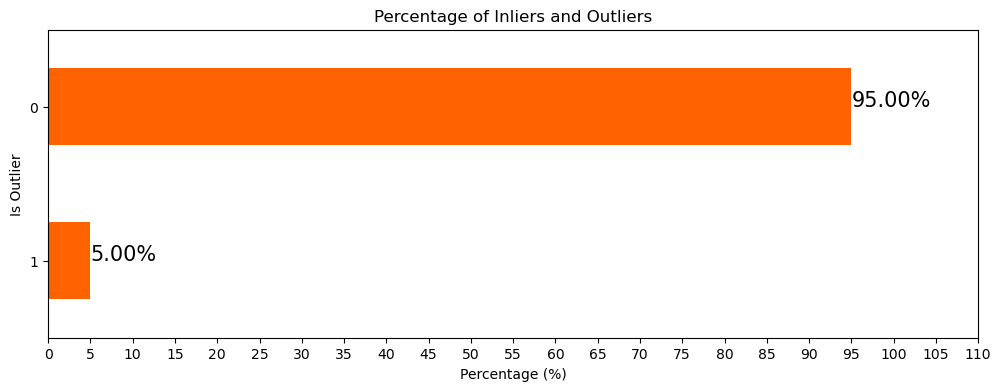

In [33]:
#Calculate the percentage of inliers and outliers
outlier_percentage = customer_df['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()

plt.show()

We can remove the outliers

In [34]:
# Separate the outliers for analysis
outliers_data = customer_df[customer_df['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_df[customer_df['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

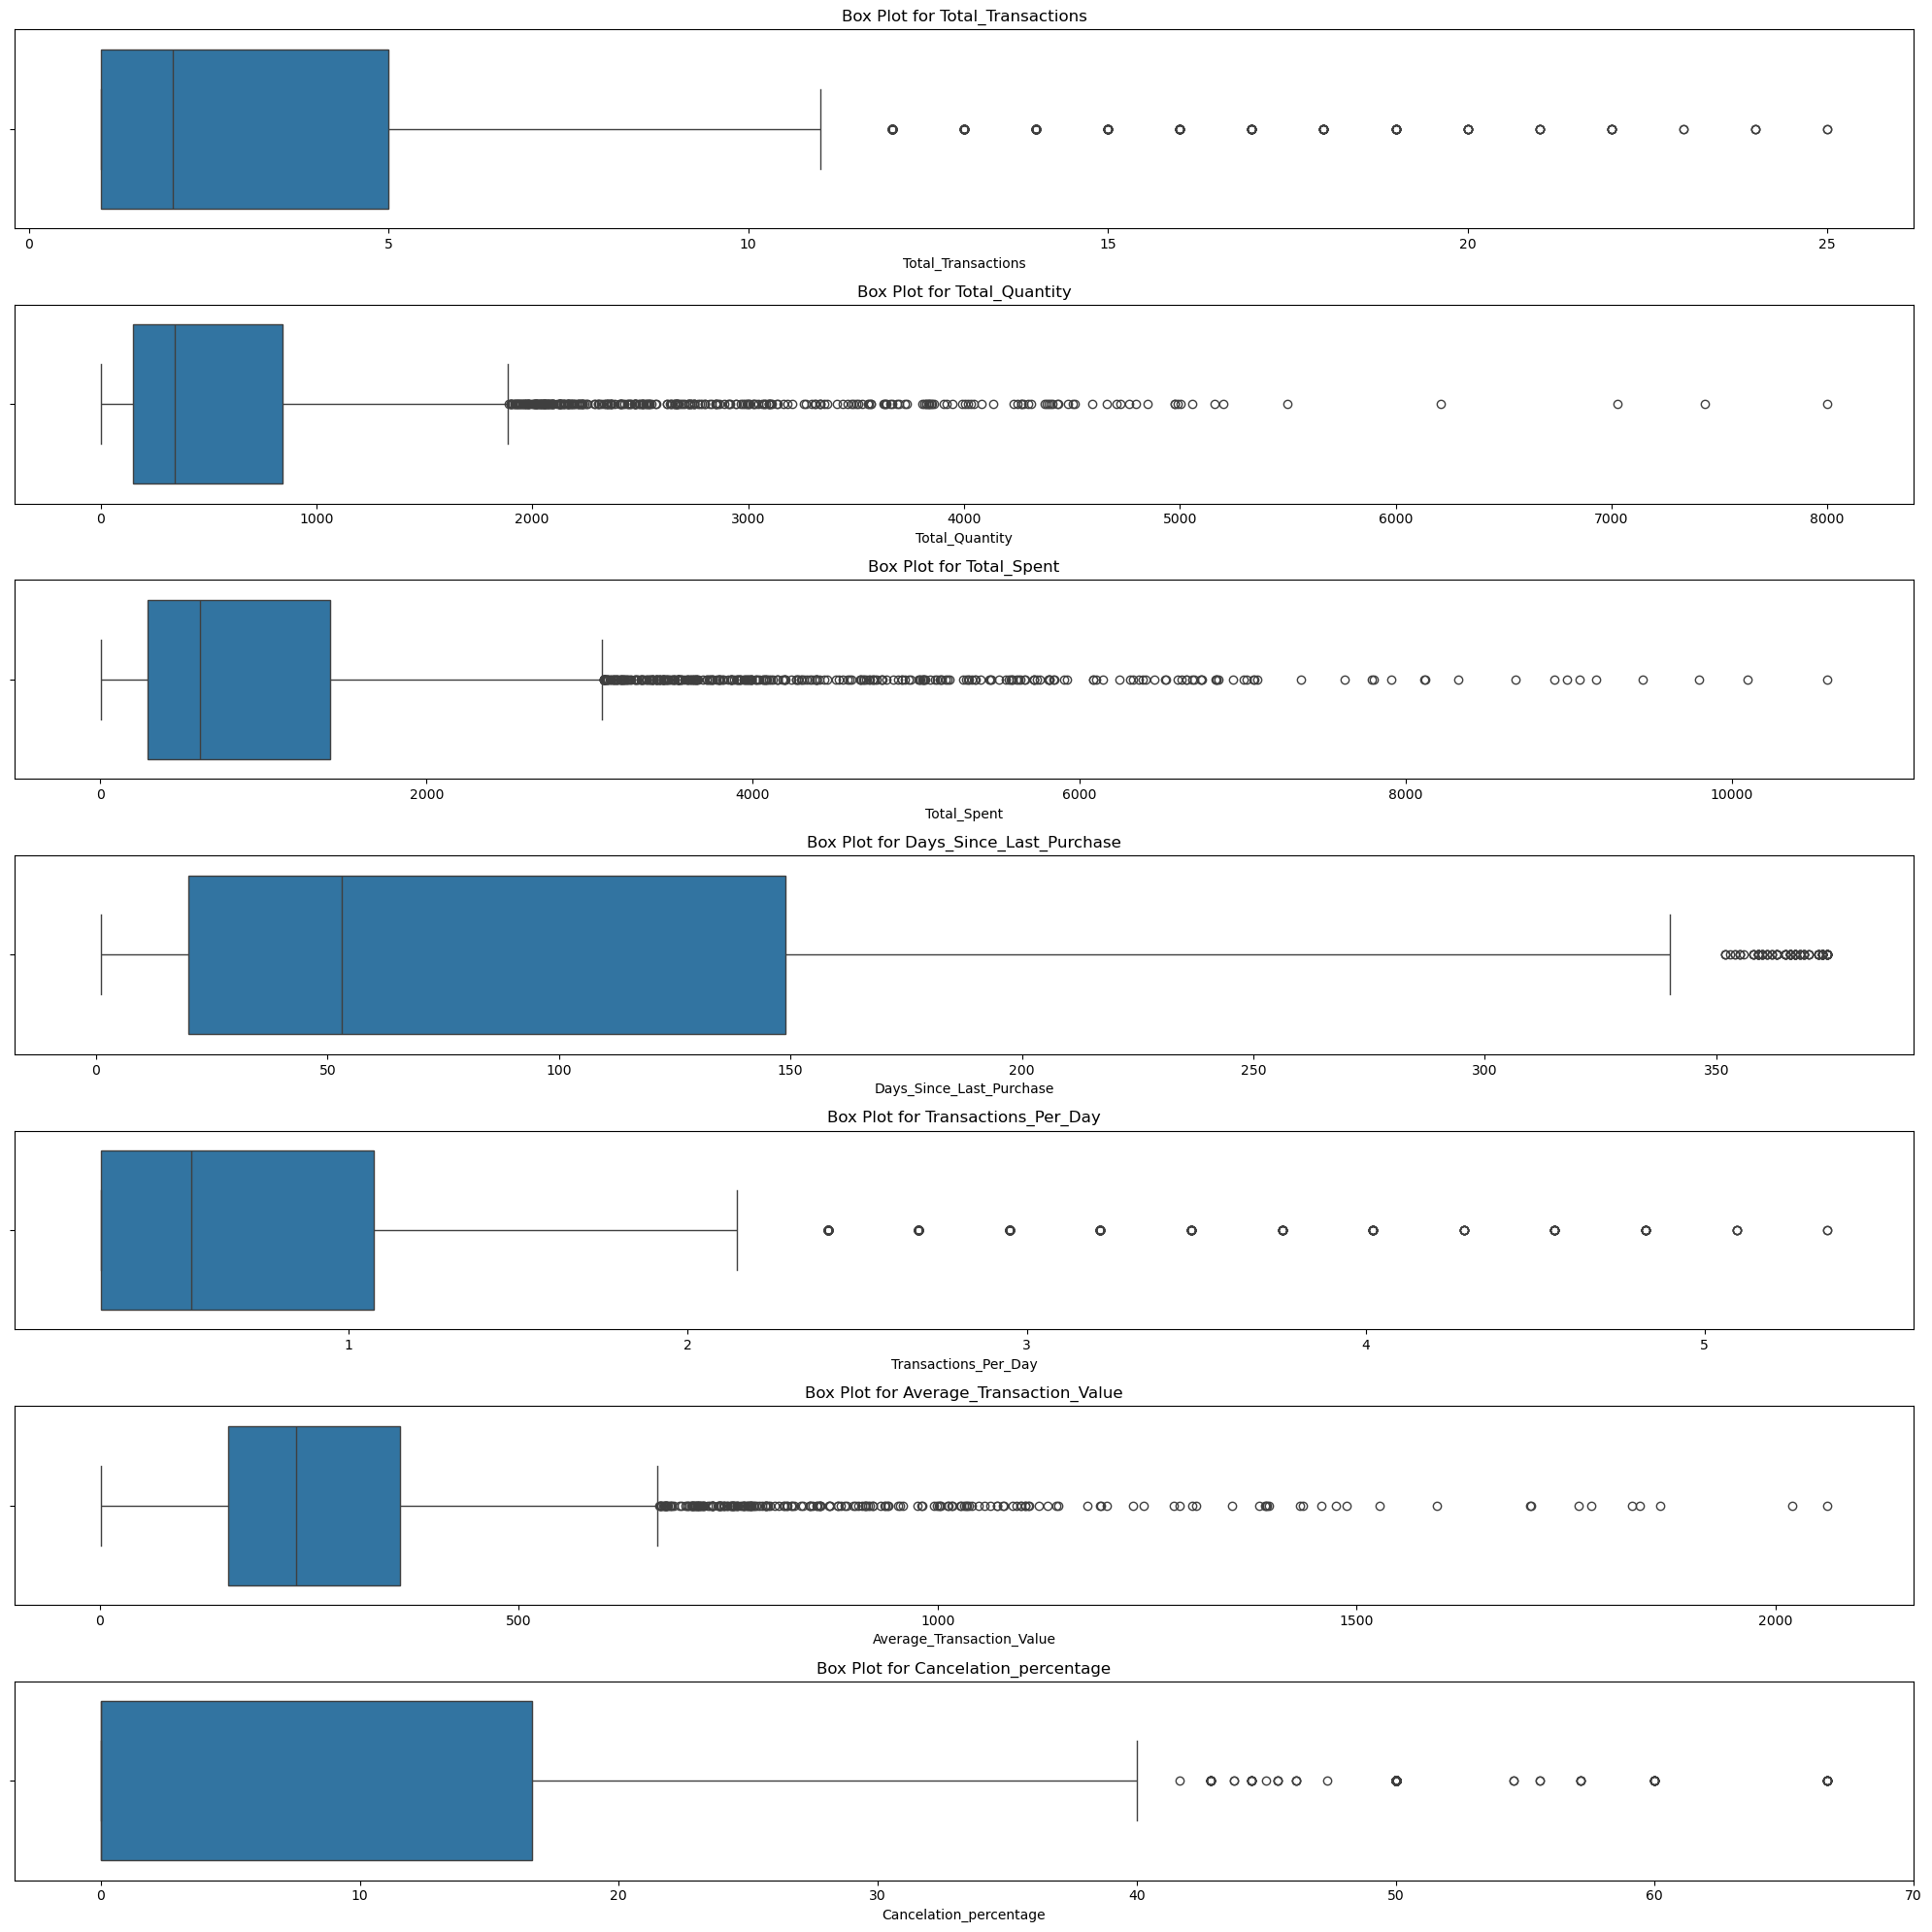

In [35]:
import seaborn as sns

data = customer_data_cleaned.drop(columns=['CustomerID'])

numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20,20))

for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 1, i+1)
    sns.boxplot(data[feature], orient='h')
    plt.title(f'Box Plot for {feature}')
    plt.xlabel(feature)
    
plt.tight_layout()
plt.show()

We tried to remove the outliers and also transform the data before detecting the outilers using Log Transfrom. The problem is that after removing the outliers either if we prior transformed the data or not with Log Transform the Clusters were becomming very similar so the performance of the model dropped.

We will keep these transformation and outlier detection and removal snippets but just for refference but not use them in the final model

In [36]:
customer_df = customer_df.drop(columns=['Is_Outlier', 'Outlier_Scores'])

## Corelation Analisys

We will do some form of a heatmap to see how these features are correlated

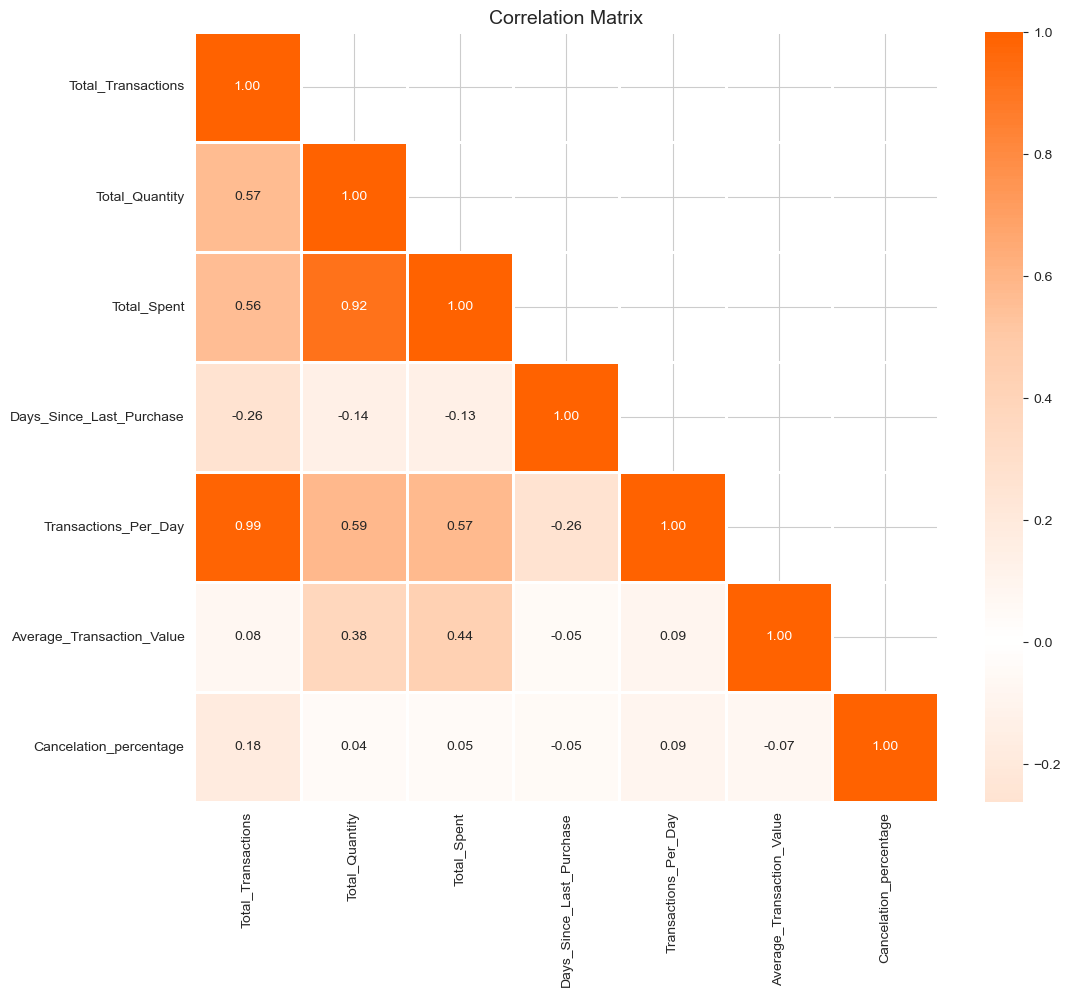

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_df.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Here we can see that some features are very strongly correlated and other are not correlated at all. Here you can decide if you keep or remove some features but for this moment we haven't removed any of them since there aren't that many

## Clustering | K-means-clustering

### Scaling the data
We will scale the data by Standardizing and Normlizing it. We can use both of the methods and see which one performs best

Standardization (Z-score normalization): This method scales the features to have a mean of 0 and a standard deviation of 1. It is a good choice when the features in your dataset have different units or magnitudes and you want to give them equal importance in the clustering process. This is particularly useful when the features follow a normal distribution.

Normalization (Min-Max scaling): This method scales the features to a specific range, typically between 0 and 1. It is suitable when the features have similar magnitudes and you want to preserve the original distribution of the data. However, it may be sensitive to outliers.

Standarization:

In [38]:
from sklearn.preprocessing import StandardScaler

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID']

# Selecting only the columns to be scaled
columns_to_scale = [col for col in customer_df.columns if col not in columns_to_exclude]
data_to_scale = customer_df[columns_to_scale]

# Standardize the selected data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(standardized_data, columns=columns_to_scale)

# Reset the index for initial dataset to start from 0 instead of 1 so it matches the scaled_df index
customer_df = customer_df.reset_index(drop=True)

# Concatenate CustomerID and the scaled data
scaled_df = pd.concat([customer_df[['CustomerID']], scaled_df], axis=1)

Normalization:

In [39]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler()
normalized_data = normalizer.fit_transform(data_to_scale)

normalized_df = pd.DataFrame(normalized_data, columns=columns_to_scale)
normalized_df = pd.concat([customer_df[['CustomerID']], normalized_df], axis=1)

### Clustering

We will use K-Means-Clustering. This will create K clusters for our data. We don't know the optimal number of clusters but we can find this by using the "Elbow Method"

Frist we will try the clustering with the Standardied dataset

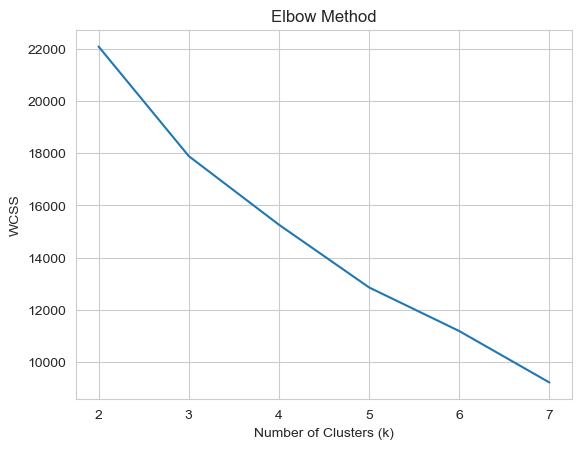

In [40]:
from sklearn.cluster import KMeans

#Within cluster sum of squares - this is a measure to check what is the optimal number of clusters it is used in the Elbow Method
wcss = []

cluster_range = range(2, 8)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k,init='k-means++', n_init=10, max_iter=100, random_state=0)
    kmeans.fit(scaled_df.drop(columns=['CustomerID']))
    wcss.append(kmeans.inertia_)  # inertia is the within-cluster sum of squares (WCSS)

# Plot the elbow curve
plt.plot(cluster_range, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

Silhouette Score for standardized data

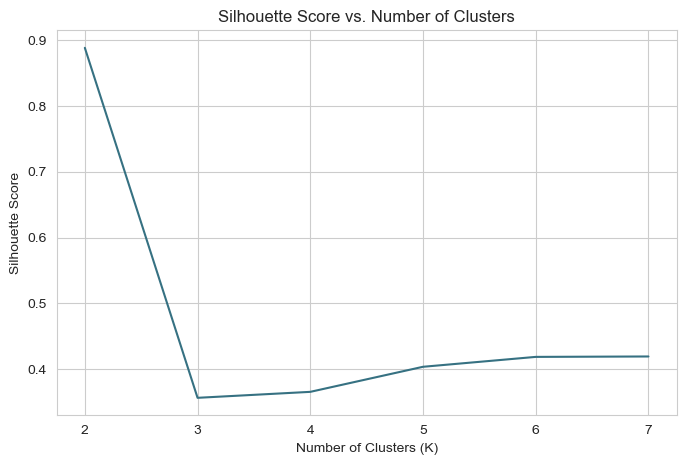

In [41]:
from sklearn.metrics import silhouette_score

X = scaled_df.drop(columns=['CustomerID'])

silhouette_list = []
cluster_range = range(2, 8)

for K in cluster_range:
    model = KMeans(n_clusters = K, init='k-means++', n_init=10, max_iter=100, random_state=0)
    clusters = model.fit_predict(X)
    s_avg = silhouette_score(X, clusters)
    silhouette_list.append(s_avg)

plt.figure(figsize=[8,5])
plt.plot(cluster_range, silhouette_list, color=(54 / 255, 113 / 255, 130 / 255))
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

Now we will try clustering with the Normalized dataset

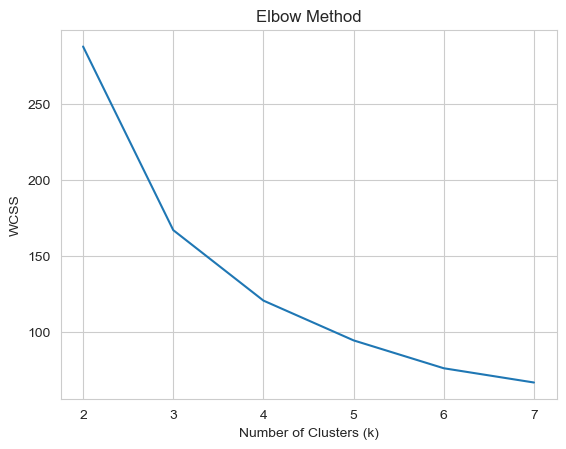

In [42]:
#Within cluster sum of squares - this is a measure to check what is the optimal number of clusters it is used in the Elbow Method
wcss = []

cluster_range = range(2, 8)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
    kmeans.fit(normalized_df.drop(columns=['CustomerID']))
    wcss.append(kmeans.inertia_)  # inertia is the within-cluster sum of squares (WCSS)

# Plot the elbow curve
plt.plot(cluster_range, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

Silhouette score for normalized data:

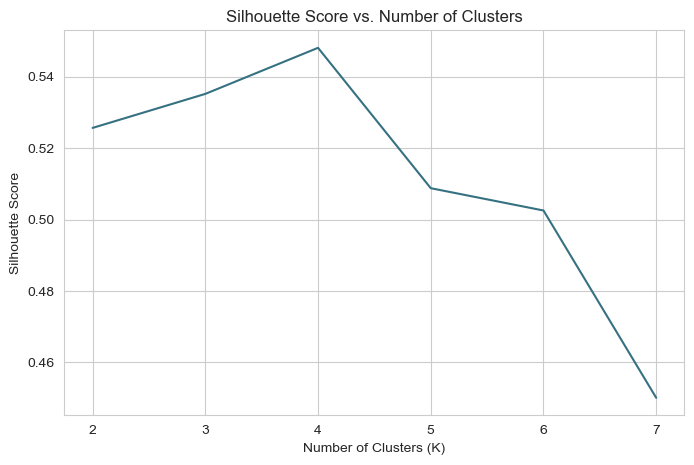

In [43]:
from sklearn.metrics import silhouette_score

X = normalized_df.drop(columns=['CustomerID'])
silhouette_list = []
cluster_range = range(2, 8)

for K in cluster_range:
    model = KMeans(n_clusters = K, init='k-means++', n_init=10, max_iter=100, random_state=0)
    clusters = model.fit_predict(X)
    s_avg = silhouette_score(X, clusters)
    silhouette_list.append(s_avg)

plt.figure(figsize=[8,5])
plt.plot(cluster_range, silhouette_list, color=(54 / 255, 113 / 255, 130 / 255))
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

We notice that when using Normalzed data it is easier to see where the optimal number of clusters is 

We notice that the optimal number of cluster is somewhere bewteen 4 and 5.
We will work with 4 clusters

In [ ]:
from collections import Counter
from sklearn.cluster import KMeans

optimal_number_of_clusters = 4

# Fit KMeans clustering model
model = KMeans(n_clusters=optimal_number_of_clusters, init='k-means++', n_init=10, max_iter=100, random_state=0)
clusters = model.fit_predict(normalized_df.drop(columns=['CustomerID']))

# Get the frequency of each cluster
cluster_frequencies = Counter(model.labels_)

# Create a mapping from old labels to new labels based on frequency - most frequent label will become 0
# By default the model asigns random labels to the clusters
label_mapping = {label: new_label for new_label, (label, _) in enumerate(cluster_frequencies.most_common())}

# Assign new labels based on frequency
new_labels = []
for label in model.labels_:
    new_labels.append(label_mapping[label])

# Assign the new labels to the 'labels_' attribute of the KMeans model
model.labels_ = new_labels

# Now you have the KMeans model with labels assigned based on frequency
customer_df['Cluster'] = new_labels
normalized_df['Cluster'] = new_labels

### Cluster Evaluation

We evaluate how the clusters are and how well they are defined. First we plot them

C:\Users\Hori\AppData\Local\Temp\ipykernel_26564\3554489462.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data = customer_df,


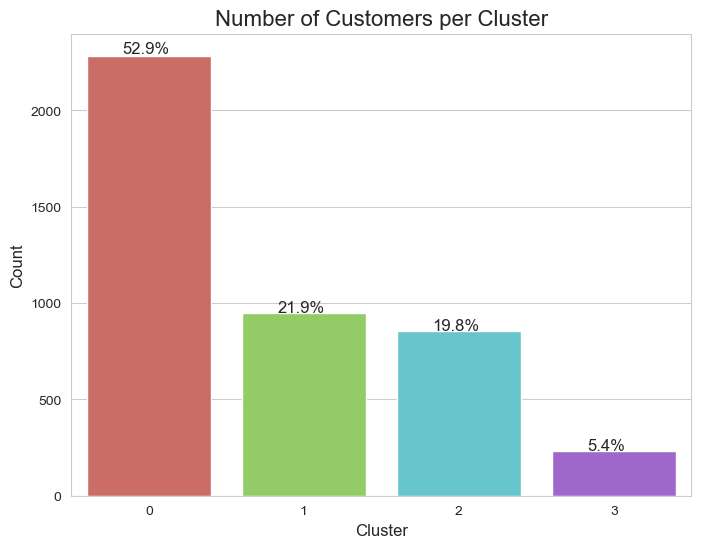

In [45]:
plt.figure(figsize = (8, 6))
ax = sns.countplot(data = customer_df,
                   x = 'Cluster',
                   palette = 'hls')
total = len(customer_df)

for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 12)

plt.title('Number of Customers per Cluster', size = 16)
plt.xlabel('Cluster', size = 12)
plt.ylabel('Count', size = 12)

plt.show()

We have a few metrics of evaluating the clusters like the following:

 - Silhouette Score: A measure to evaluate the separation distance between the clusters. Higher values indicate better cluster separation. It ranges from -1 to 1.

- Calinski Harabasz Score: This score is used to evaluate the dispersion between and within clusters. A higher score indicates better defined clusters.
- Davies Bouldin Score: It assesses the average similarity between each cluster and its most similar cluster. Lower values indicate better cluster separation.

In [46]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Compute number of customers
num_observations = len(normalized_df)
X = normalized_df.drop(columns=['CustomerID', 'Cluster'])

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

print("Number of Observations", num_observations)
print(50 * '*')
print("Silhouette Score", sil_score)
print("Calinski Harabasz Score", calinski_score)
print("Davies Bouldin Score", davies_score)

Number of Observations 4320
**************************************************
Silhouette Score 0.5481461388663462
Calinski Harabasz Score 4945.590778554716
Davies Bouldin Score 0.6841854670059084


- The Silhouette Score of approximately 0.54, although not close to 1, still indicates a fair amount of separation between the clusters. It suggests that the clusters are somewhat distinct, but there might be slight overlaps between them. Generally, a score closer to 1 would be ideal, indicating more distinct and well-separated clusters.

- The Calinski Harabasz Score is 4945.59, which is considerably high, indicating that the clusters are well-defined. A higher score in this metric generally signals better cluster definitions, thus implying that our clustering has managed to find substantial structure in the data.

- The Davies Bouldin Score of 0.68 is a good score, indicating a low level of similarity between each cluster and its most similar one. A lower score is generally better as it indicates less similarity between clusters, and thus, our score here suggests a decent separation between the clusters.

### Cluster interpretation

We will create a radar chart for each cluster to visualize the centroid values for each cluster across different features. This can give a quick visual comparison of the profiles of different clusters.To construct the radar charts, it's essential to first compute the centroid for each cluster. This centroid represents the mean value for all features within a specific cluster

We standardize the data to bring it to a more aproachable scale

In [47]:
from sklearn.preprocessing import StandardScaler

# We create a new df where the index is the CustomerID column
indexed_customer_df = customer_df.set_index('CustomerID')

#We standaridze the data without Cluster column
scalar = StandardScaler()
customer_standardized = scalar.fit_transform(indexed_customer_df.drop(columns=['Cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(customer_standardized, columns=indexed_customer_df.columns[:-1], index=indexed_customer_df.index)
df_customer_standardized['Cluster'] = indexed_customer_df['Cluster']


# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('Cluster').mean()

Radar Chart

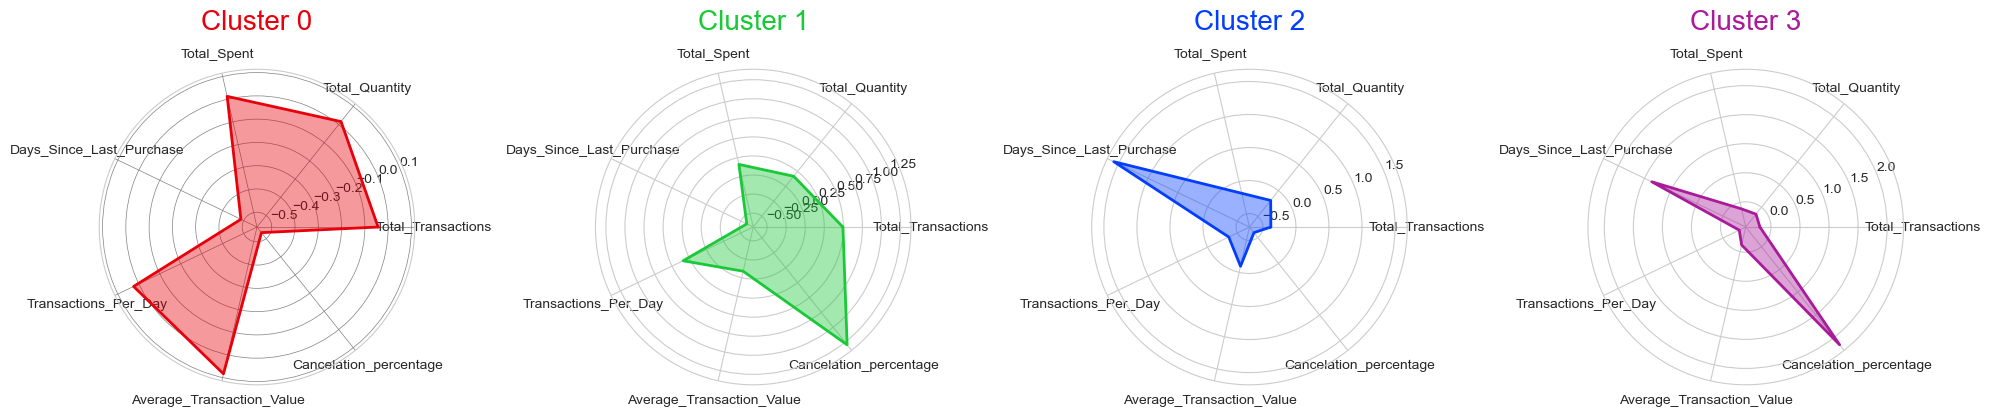

In [48]:
# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=optimal_number_of_clusters)


colors = ['#e8000b', '#1ac938', '#023eff', '#A91B9A']

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)


#Add labels on radar
for i in range(0, optimal_number_of_clusters): 
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1])
    
# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

We use a histogram plot to see the feature values distribution. We can plot histograms for each feature segmented by the cluster labels. These histograms will allow us to visually inspect the distribution of feature values within each cluster

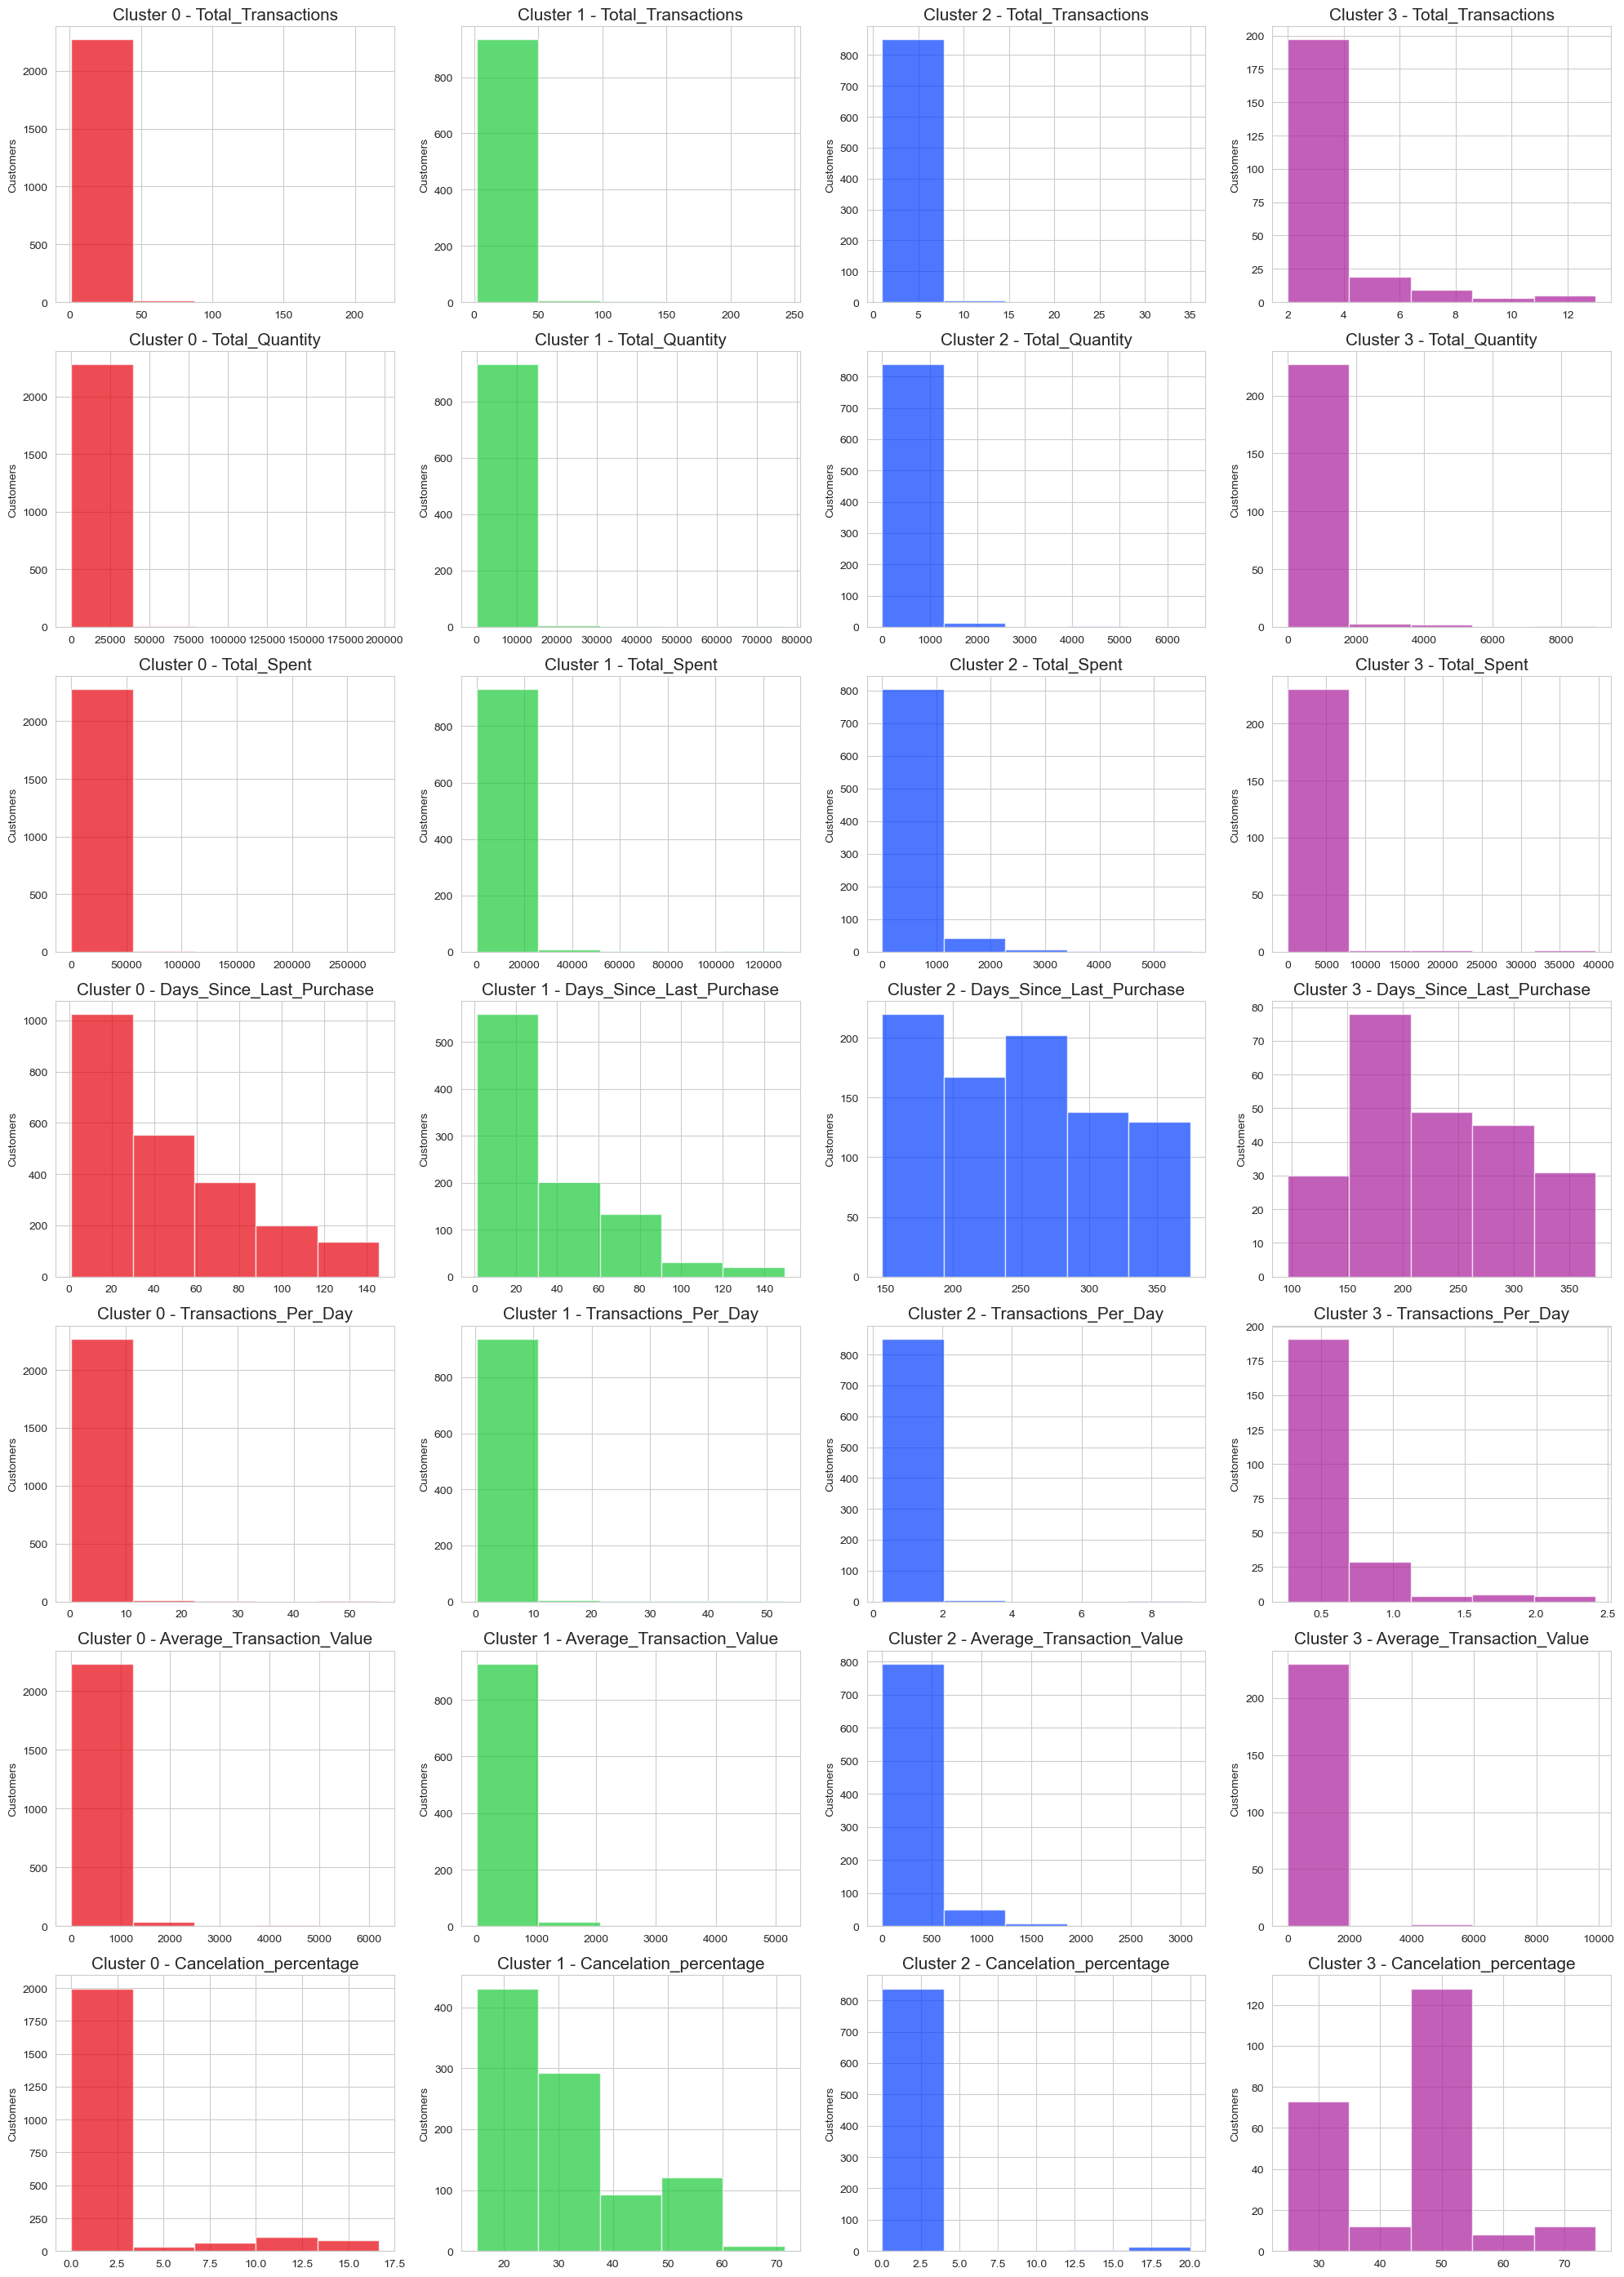

In [49]:
dataset = customer_df

# Plot histograms for each feature segmented by the clusters
features = dataset.columns[1: -1]
clusters = dataset['Cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, optimal_number_of_clusters * n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = dataset[dataset['Cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=5, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('Customers')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

### Our Conclusions

1. **Cluster 0**

They are big spenders
They buy a lot of items and have the largest share of transactions/transactions per day and average transaction value

They are also recent buyers meaning that they are engaged with our shop

Also the cancelation percentage is low meaning that they finish the transactions

We can say that these are our best customers and we should treat them properly to maintain this status



2. **Cluster 1**

Their spending rate is below average, same for the quantity and total transactions made
They have a high rate of cancelled orders meaning that they are not pleased every time with our products
They are also very active and engaged with the shop and are having an average number of transactions per day

We should see why they have such high rate of cancelled orders and address this issue and review the products that
are on those cancelled orders


3. **Cluster 2**

These customers spent a low amount of money and have a few number of transactions and quantity ordered
They cancel very few transactions. These customers seem to be inactive, they lost the interest in our score quite fast
since they haven't ordered for a long time. Also the number of transactions/day is quite low. This means that either they are
just occasionally customers or the products did not satisfy their needs.


4. **Cluster 3**

These customers bring the lowest amount of income for us, they have the fewest number of transactions and quantity ordered. 
Their cancelation rate is the highest meaning that they are very unsatisfied with our products and a lot of time has passed since
they haven't made any transaction. 
This makes us believe that these are churn clients and this is because the products they bought were quite bad.

We should see what products are most ordered for this cluster and understand why they have such high cancelation rate because 
This might be the reason why we lost these customers.